# <font color='blus'>Table of contents</font>

In [269]:
from jyquickhelper import add_notebook_menu
add_notebook_menu(first_level=1, last_level=4, header="Result issued from biais metrics")

# <font color='blus'>Abstract</font>

    This notebook implement both data-preparation and CNN model building provided from 
    Kaggle : https://www.kaggle.com/c/jigsaw-unintended-bias-in-toxicity-classification/overview/evaluation
    
    It is used in order to compare bias performances and classification performances of submission model (the one submitted for Kaggle competition) with the one delivered by Kaggle (benchmark model).

# <font color='blus'>Software engineering</font>
<img src="./img/SoftwareEngineeringBenchmark.png">

# <font color='blus'>1. Benchmark algorithm</font>

In [85]:
from sklearn import metrics
%matplotlib inline

%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings('ignore')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [182]:
import p9_util_benchmark
p9_util_benchmark.dict_param_benchmark

{'root_directory': './data/benchmark/',
 'format_file': '.dill',
 'format_model': '.h5',
 'root_filename_benchmark': './data/benchmark/df_sample_benchmark_',
 'root_filename_model': 'model_jigsaw_',
 'n_sample': None,
 'n_sample_train': None,
 'is_dataset_reloaded': True,
 'model_type': 'benchmark',
 'is_model_reloaded': True,
 'is_embedding_layer': True,
 'threshold': 0.5,
 'embeddings_dimension': 100,
 'val_score_max': True,
 'epochs': 10}

In [4]:
import p9_util_config
p9_util_config.dict_param_keras_cnn

{'dict_param_keras': {'input_dim': (250, 100),
  'batch_size': 500,
  'nb_epoch': 10,
  'verbose': 1,
  'dropout_rate': 0.3,
  'regul': (None, None),
  'is_batch_normalized': True,
  'lr': 0.001,
  'nbClasses': 2},
 'filter_size': 3,
 'stride_size': 1,
 'pool_size': 2,
 'pool_stride': 2,
 'nb_filter': 256,
 'conv_layer': 4,
 'nb_dense_neuron': 128,
 'dense_layer': 1,
 'dense_layer_decrease_rate': 1,
 'list_channel': [],
 'list_filter_channel': []}

## <font color='blus'>1.1 Data preparation</font>
    
    Depending configuration parameters from p9_util_benchmark.dict_param_benchmark, data is prepared 
    or prepared data is read from hard drive.
    

In [183]:
import pandas as pd
from keras.preprocessing.text import Tokenizer
from sklearn import model_selection

import keras

import p5_util
import p9_util_benchmark

#filename = './data/benchmark/model_jigsaw_benchmark.h5'

n_sample = p9_util_benchmark.dict_param_benchmark['n_sample']
filename_benchmark = p9_util_benchmark.build_filename_benchmark()
print(n_sample,filename_benchmark)

#-------------------------------------------------------------------------------
# Loading or building dataset
#-------------------------------------------------------------------------------
if p9_util_benchmark.dict_param_benchmark['is_dataset_reloaded'] :
   
    #-------------------------------------------------------------
    # Load validation dataframe for benchmark
    #-------------------------------------------------------------
    df_validate = p5_util.object_load(filename_benchmark)

    
    #-------------------------------------------------------------
    # Save train dataset into a file.
    #-------------------------------------------------------------
    filename_train_dataset = p9_util_benchmark.build_filename_benchmark(is_train=True)
    df_train = p5_util.object_load(filename_train_dataset,is_verbose=True )
    
    
    #-------------------------------------------------------------
    # Load text tokenizer for data-preparation.
    #-------------------------------------------------------------
    tokenizer = p5_util.object_load(p9_util_benchmark.build_filename_tokenizer())
else :
    #-------------------------------------------------------------
    # Build dataset for train and validation, 
    #-------------------------------------------------------------
    df_train = pd.read_csv('./data/train.csv.zip', compression='zip', header=0, sep=',', quotechar='"')
    df_train['comment_text'] = df_train['comment_text'].apply(lambda x : x.lower())
    df_train['comment_text'] = df_train['comment_text'].astype(str)

    df_train = p9_util_benchmark.convert_dataframe_to_bool(df_train, \
                                                           dict_param_benchmark_=p9_util_benchmark.dict_param_benchmark)

    df_train, df_validate = model_selection.train_test_split(df_train, test_size=0.2)
    print('%d train comments, %d validation comments' % (len(df_train), len(df_validate)))
    
    #-------------------------------------------------------------
    # Save validation dataset into a file.
    #-------------------------------------------------------------
    filename_valid_dataset = p9_util_benchmark.build_filename_benchmark()
    p5_util.object_dump(df_validate.sample(n_sample),filename_valid_dataset,is_verbose=True )
    
    #-------------------------------------------------------------
    # Save train dataset into a file.
    #-------------------------------------------------------------
    filename_train_dataset = p9_util_benchmark.build_filename_benchmark(is_train=True)
    p5_util.object_dump(df_train,filename_train_dataset,is_verbose=True )
    
    #-------------------------------------------------------------
    # Create a text tokenizer and save it.
    #-------------------------------------------------------------
    tokenizer = Tokenizer(num_words=p9_util_benchmark.MAX_NUM_WORDS)
    tokenizer.fit_on_texts(df_train[p9_util_benchmark.TEXT_COLUMN])
    filename_tokenizer = p9_util_benchmark.build_filename_tokenizer()
    p5_util.object_dump(tokenizer,filename_tokenizer, is_verbose=True )
    
    #-------------------------------------------------------------
    # Save parameters configuration into a file.
    #-------------------------------------------------------------
    filename_param = p9_util_benchmark.build_filename_param(p9_util_benchmark.dict_param_benchmark)
    p5_util.object_dump(p9_util_benchmark.dict_param_benchmark,filename_param, is_verbose=True )

None ./data/benchmark/df_sample_benchmark_valid_FULL.dill
p5_util.object_load : fileName= ./data/benchmark/df_sample_benchmark_valid_FULL.dill
p5_util.object_load : fileName= ./data/benchmark/df_sample_benchmark_train_FULL.dill
p5_util.object_load : fileName= ./data/benchmark/tokenizer_FULL.dill


#### Rebuild validation dataframe from both train dataset and full dataset

In [103]:
import p9_util_benchmark

if False :
    df_full = pd.read_csv('./data/train.csv.zip', compression='zip', header=0, sep=',', quotechar='"')

    arr_index_train = df_train.index
    arr_index_valid = [index for index in df_full.index if index not in arr_index_train]

    df_validate = df_full.loc[arr_index_valid]
    MODEL_NAME = 'predict'
    df_validate = p9_util_benchmark.convert_dataframe_to_bool(df_validate, \
                                                          dict_param_benchmark_=p9_util_benchmark.dict_param_benchmark,
                                                          pred_column = MODEL_NAME)
#if True:
    filename_valid_dataset = p9_util_benchmark.build_filename_benchmark()
    print(filename_valid_dataset)

    p5_util.object_dump(df_validate.sample(len(df_validate)),filename_valid_dataset,is_verbose=True )

## <font color='blus'>1.2 Model from benchmark </font>
    
    Depending configuration parameters from p9_util_benchmark.dict_param_benchmark, model is built 
    or model is read from hard drive.
    

In [12]:
import keras
import p5_util
import p9_util_benchmark

#-------------------------------------------------------------------------------
# Loading or building model
#-------------------------------------------------------------------------------    
if p9_util_benchmark.dict_param_benchmark['is_model_reloaded'] :
    #-------------------------------------------------------------
    # Load benchmark model.
    #-------------------------------------------------------------
    filename_model = p9_util_benchmark.build_filename_model()
    print("Loding model= {}".format(filename_model))
    model = keras.models.load_model(filename_model)
else :
    #-------------------------------------------------------------
    # Build benchmark model then save it.
    #-------------------------------------------------------------
    model,list_callback = p9_util_benchmark.build_model(p9_util_benchmark.dict_param_benchmark, \
                                                        p9_util_config.dict_param_keras_cnn)
    #model = p9_util_benchmark.train_benchmark_model(df_train, df_validate, tokenizer)

    filename_model = p9_util_benchmark.build_filename_model()
    model.save(filename_model)
    
        

Loding model= ./data/benchmark/model_jigsaw_benchmark_sampleFULL_threshold0.5_best.h5


In [13]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 250)               0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 250, 100)          35256200  
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 250, 128)          25728     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 50, 128)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 50, 128)           49280     
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 10, 128)           0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 10, 128)           65664     
__________

In [7]:
p9_util_config.dict_param_keras_cnn

{'dict_param_keras': {'input_dim': (250, 100),
  'batch_size': 500,
  'nb_epoch': 10,
  'verbose': 1,
  'dropout_rate': 0.3,
  'regul': (None, None),
  'is_batch_normalized': True,
  'lr': 0.001,
  'nbClasses': 2},
 'filter_size': 3,
 'stride_size': 1,
 'pool_size': 2,
 'pool_stride': 2,
 'nb_filter': 256,
 'conv_layer': 4,
 'nb_dense_neuron': 128,
 'dense_layer': 1,
 'dense_layer_decrease_rate': 1,
 'list_channel': [],
 'list_filter_channel': []}

In [ ]:
import p9_util_benchmark
model, history = p9_util_benchmark.train_benchmark_model(model, df_train, df_validate, tokenizer,
                                                         dict_param_keras_cnn=p9_util_config.dict_param_keras_cnn,
                                                        list_callback = list_callback)

Data preparation...

Batch size= 500
Model training...
Train on 1443899 samples, validate on 360975 samples
Epoch 1/10
1443899/1443899 [==============================] - 870s 603us/step - loss: 0.1707 - acc: 0.9402 - val_loss: 0.1494 - val_acc: 0.9448

Epoch 00001: val_acc improved from -inf to 0.94481, saving model to ./data/benchmark/model_jigsaw_benchmark_sampleFULL_threshold0.5_best.h5
Epoch 2/10
1443899/1443899 [==============================] - 917s 635us/step - loss: 0.1493 - acc: 0.9460 - val_loss: 0.1506 - val_acc: 0.9479

Epoch 00002: val_acc improved from 0.94481 to 0.94789, saving model to ./data/benchmark/model_jigsaw_benchmark_sampleFULL_threshold0.5_best.h5
Epoch 3/10
1443899/1443899 [==============================] - 988s 685us/step - loss: 0.1449 - acc: 0.9470 - val_loss: 0.1429 - val_acc: 0.9480

Epoch 00003: val_acc improved from 0.94789 to 0.94797, saving model to ./data/benchmark/model_jigsaw_benchmark_sampleFULL_threshold0.5_best.h5
Epoch 4/10
1443899/1443899 [===

    History from trained model is saved 

In [15]:
import p5_util
import p9_util_benchmark

filename_history = p9_util_benchmark.build_filename_history(p9_util_benchmark.dict_param_benchmark)
p5_util.object_dump(history,filename_history, is_verbose=True)

object_dump: file name= ./data/benchmark/history_benchmark_100D_FULL_.dill


In [3]:
import p5_util
import p9_util_benchmark
filename_history = p9_util_benchmark.build_filename_history(p9_util_benchmark.dict_param_benchmark)
filename_history

history = p5_util.object_load(filename_history)

W1103 13:10:02.604157 140002609624896 lazy_loader.py:50] 
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

W1103 13:10:02.604851 140002609624896 deprecation_wrapper.py:119] From /home/bangui/anaconda3/envs/python36/lib/python3.6/site-packages/adanet/tf_compat/__init__.py:96: The name tf.losses.Reduction is deprecated. Please use tf.compat.v1.losses.Reduction instead.

W1103 13:10:02.616476 140002609624896 deprecation_wrapper.py:119] From /home/bangui/Dropbox/Perso/Formation/openclassrooms/OC_Datascientist/Kaggle/p8_util_config.py:137: The name tf.train.AdamOptimizer is deprecated. Please use tf.compat.v1.train.AdamOptimizer instead.



p5_util.object_load : fileName= ./data/benchmark/history_benchmark_100D_FULL_.dill


W1103 13:10:03.059059 140002609624896 deprecation_wrapper.py:119] From /home/bangui/anaconda3/envs/python36/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W1103 13:10:03.061770 140002609624896 deprecation_wrapper.py:119] From /home/bangui/anaconda3/envs/python36/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W1103 13:10:03.080543 140002609624896 deprecation_wrapper.py:119] From /home/bangui/anaconda3/envs/python36/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:3976: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.

W1103 13:10:03.136088 140002609624896 deprecation_wrapper.py:119] From /home/bangui/anaconda3/envs/python36/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:131: The name tf.get_default_graph is deprecated. Pl

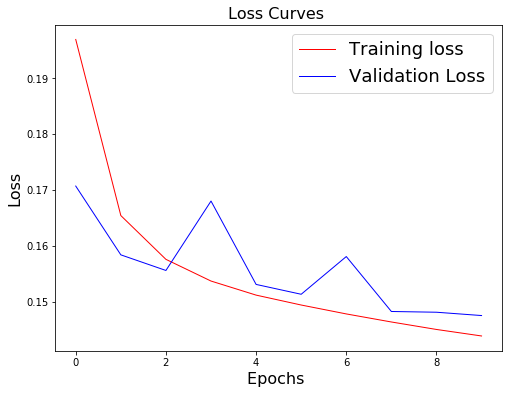

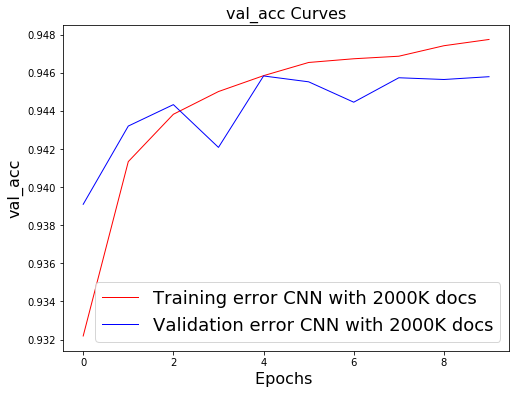

In [8]:
import p7_util
#legend='length='+str(max_length)
legend = "CNN with 2000K docs"
model = None

list_model_acc_value = p7_util.p7_plot_cnn_history(model, None, None, history=history, legend=legend)

    Predictions are applied over validation dataset.

In [112]:
import p9_util_benchmark
MODEL_NAME = 'predict'
df_validate[MODEL_NAME] = model.predict(p9_util_benchmark.pad_text(df_validate[p9_util_benchmark.TEXT_COLUMN], tokenizer),
                                       verbose=1)[:, 1]

#-------------------------------------------------------------
# Save validation dataset containing predictions 
#-------------------------------------------------------------
filename_valid_dataset = p9_util_benchmark.build_filename_benchmark()
filename_valid_dataset

p5_util.object_dump(df_validate,filename_valid_dataset,is_verbose=True )

360975/360975 [==============================] - 186s 514us/step
object_dump: file name= ./data/benchmark/df_sample_benchmark_valid_FULL.dill


In [11]:
df_validate.sample(5)

,id,target,comment_text,severe_toxicity,obscene,identity_attack,insult,threat,asian,atheist,...,rating,funny,wow,sad,likes,disagree,sexual_explicit,identity_annotator_count,toxicity_annotator_count,predict
1484112,5936379,False,ohhhh. 😛😄,0.0,0.0,0.0,0.0,0.0,NaN,NaN,...,approved,0,0,0,0,0,0.0,0,4,0.072783
115115,382827,False,glad to see the federal subsistence board is w...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,approved,0,0,0,3,0,0.0,4,4,0.057490
956027,5288107,False,"hardly peanuts, and certainly more than ""absol...",0.0,0.0,0.0,0.0,0.0,NaN,NaN,...,approved,0,0,0,1,0,0.0,0,4,0.009253
940769,5269611,False,so did the g+m when in a pre-election editoria...,0.0,0.0,0.0,0.0,0.0,NaN,NaN,...,approved,0,0,0,4,0,0.0,0,4,0.008685
779017,5073869,False,"people are here without documentation, or with...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,approved,0,0,0,1,0,0.0,4,4,0.027935


## <font color='blus'>1.3 Bias computation </font>    

In [184]:
import p9_util_metrics
df_bias_metrics = p9_util_metrics.compute_bias_metrics_for_model(df_validate, 
                                                                 p9_util_metrics.IDENTITY_COLUMNS, 
                                                                 MODEL_NAME, 
                                                                 p9_util_benchmark.TOXICITY_COLUMN)
df_bias_metrics

,bnsp_auc,bpsn_auc,subgroup,subgroup_auc,subgroup_size
6,0.959931,0.768903,black,0.807377,3006
7,0.965931,0.773480,white,0.819055,5077
2,0.963686,0.781776,homosexual_gay_or_lesbian,0.820112,2221
5,0.957757,0.819413,muslim,0.845473,4262
4,0.948680,0.857917,jewish,0.862545,1509
8,0.948939,0.856340,psychiatric_or_mental_illness,0.864638,982
0,0.946800,0.875431,male,0.883611,9050
1,0.944072,0.883673,female,0.889211,10671
3,0.937363,0.909032,christian,0.907213,8081


In [185]:
import p9_util_metrics
overall_auc = p9_util_metrics.calculate_overall_auc(df_validate, MODEL_NAME, p9_util_metrics.TOXICITY_COLUMN)
print("Global AUC= {}".format(overall_auc))

0.9358750872482381

In [186]:
import p9_util_metrics

p9_util_metrics.get_final_metric(df_bias_metrics, overall_auc)

Bias score contribution : 0.6578661928087628


0.8918349646208223

## <font color='blus'>1.4 Binay classification performances </font>    

In [189]:
arr_index = df_validate[['target', MODEL_NAME, ]].sample(3).index

df_validate[['target', MODEL_NAME, ]].loc[arr_index]

,target,predict
507152,False,0.011748
385223,False,0.010401
1242654,False,0.002137


    Convert predictions and targets into binary values

In [191]:
df_validate['bool_predict'] = np.where(df_validate[MODEL_NAME] >= threshold, True, False)

df_validate['bin_predict'] = np.where(df_validate[MODEL_NAME] >= threshold, 1, 0)

df_validate['bin_target'] = np.where(df_validate['target'] == True, 1, 0)

In [196]:
df_validate[['target', MODEL_NAME, 'bool_predict','bin_target', 'bin_predict']].loc[arr_index]

,target,predict,bool_predict,bin_target,bin_predict
507152,False,0.011748,False,0,0
385223,False,0.010401,False,0,0
1242654,False,0.002137,False,0,0


[0, 1]

Confusion matrix for all classes : 

[[326929   5317]
 [ 13367  15362]]

Normalized confusion matrix
[[0.9839968  0.0160032 ]
 [0.46527899 0.53472101]]
Confusion matrix, without normalization
[[326929   5317]
 [ 13367  15362]]

TP rate = [0.         0.53472101 1.        ]
FP rate = [0.        0.0160032 1.       ]
AUC = 0.7593589055817804


array([0, 0, 0, ..., 0, 1, 0])

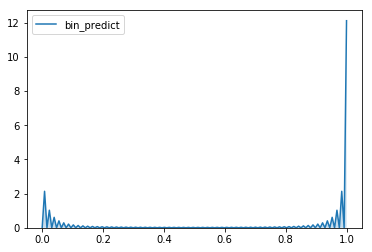

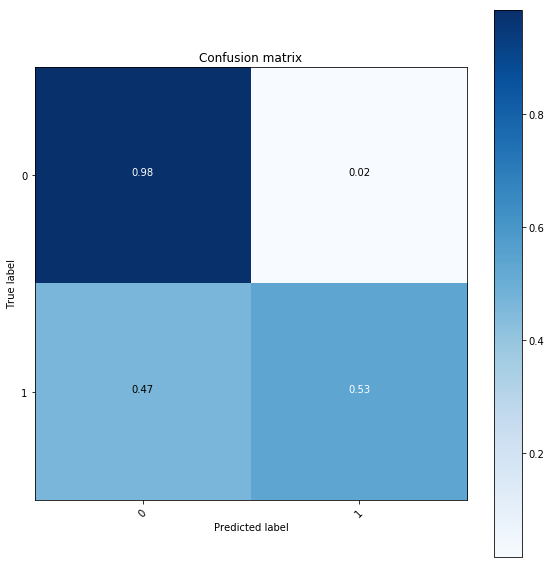

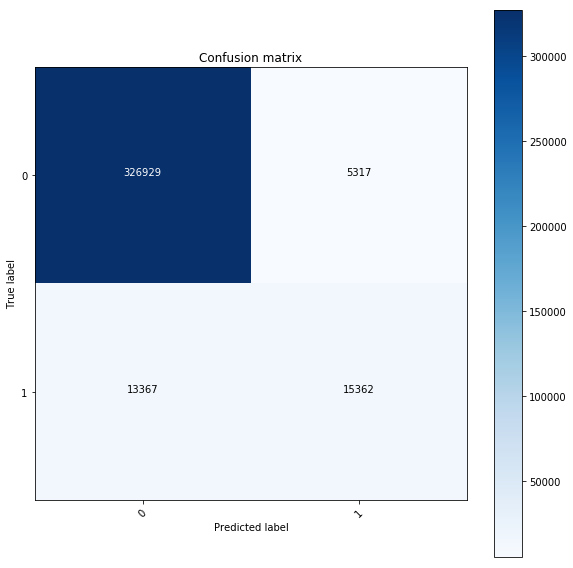

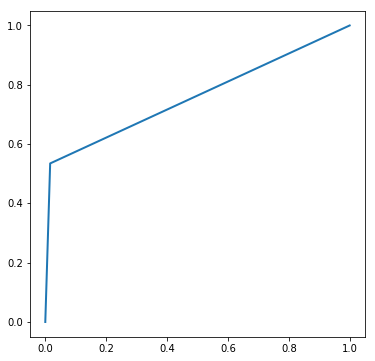

In [203]:
Xeval=None
p9_util.display_class_performance(model, Xeval, df_validate['bin_target'], \
                              is_binary=True, y_pred= df_validate['bin_predict'], nb_classes=2,\
                              title="Confusion matrix") 

# <font color='blus'>2. Sampling effect over benchmark algorithm</font>

    Benchmark algorithm is trained with the same sampling size then the submission algorithm and 
    performances are compared with the two algorithms.
    

In [223]:
from sklearn import metrics
%matplotlib inline

%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings('ignore')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Build model with tokenizer and embeddings matrix already built.

Cofiguration structure, `p9_util_benchmark.dict_param_benchmark` has to be updated according following parameters : 

* Parameter `model_type` is fixed to `'benchmark'`
* Parameter `is_dataset_reloaded` is fixed to `True`
* Parameter `is_model_reloaded` is fixed to `False`
* Parameter `is_embedding_reloaded` is fixed to `True`


In [261]:
import p9_util_benchmark
p9_util_benchmark.dict_param_benchmark

{'root_directory': './data/benchmark/',
 'format_file': '.dill',
 'format_model': '.h5',
 'root_filename_benchmark': './data/benchmark/df_sample_benchmark_',
 'root_filename_model': 'model_jigsaw_',
 'n_sample': None,
 'n_sample_train': None,
 'model_type': 'benchmark',
 'is_model_reloaded': False,
 'is_embedding_layer': True,
 'is_dataset_reloaded': True,
 'is_embedding_reloaded': True,
 'threshold': 0.5,
 'embeddings_dimension': 100,
 'val_score_max': True,
 'epochs': 10}

In [262]:
import keras
import p5_util
import p9_util_config
import p9_util_benchmark

#-------------------------------------------------------------------------------
# Loading or building model
#-------------------------------------------------------------------------------    
if p9_util_benchmark.dict_param_benchmark['is_model_reloaded'] :
    #-------------------------------------------------------------
    # Load benchmark model.
    #-------------------------------------------------------------
    filename_model = p9_util_benchmark.build_filename_model()
    print("Loding model= {}".format(filename_model))
    model = keras.models.load_model(filename_model)
else :
    #-------------------------------------------------------------
    # Build benchmark model then save it.
    #-------------------------------------------------------------
    model,list_callback = p9_util_benchmark.build_model(p9_util_benchmark.dict_param_benchmark, \
                                                        p9_util_config.dict_param_keras_cnn)
    #model = p9_util_benchmark.train_benchmark_model(df_train, df_validate, tokenizer)

    filename_model = p9_util_benchmark.build_filename_model()
    model.save(filename_model)
    
        

p5_util.object_load : fileName= ./data/benchmark/tokenizer_FULL.dill
Loading embeddings matrix...
p5_util.object_load : fileName= ./data/benchmark/embedding_matrix_100D_FULL.dill
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 250)               0         
_________________________________________________________________
embedding_4 (Embedding)      (None, 250, 100)          35256200  
_________________________________________________________________
conv1d_10 (Conv1D)           (None, 250, 128)          25728     
_________________________________________________________________
max_pooling1d_10 (MaxPooling (None, 50, 128)           0         
_________________________________________________________________
conv1d_11 (Conv1D)           (None, 50, 128)           49280     
_________________________________________________________________
max_pooling1d_11 (MaxPooling 

Configuration has to be updated into file `p9_util_benchmark.dict_param_benchmark` in a way that dataset is reloaded and model is built and trained over the 
sampling.

* Parameter `model_type` is fixed to `'benchmark'`
* Parameter `is_dataset_reloaded` is fixed to `True`
* Parameter `is_model_reloaded` is fixed to `False`
* Parameter `is_tokenizer_reloaded` is fixed to `True`


In [263]:
import p9_util_benchmark
p9_util_benchmark.dict_param_benchmark

{'root_directory': './data/benchmark/',
 'format_file': '.dill',
 'format_model': '.h5',
 'root_filename_benchmark': './data/benchmark/df_sample_benchmark_',
 'root_filename_model': 'model_jigsaw_',
 'n_sample': None,
 'n_sample_train': None,
 'model_type': 'benchmark',
 'is_model_reloaded': False,
 'is_embedding_layer': True,
 'is_dataset_reloaded': True,
 'is_embedding_reloaded': True,
 'threshold': 0.5,
 'embeddings_dimension': 100,
 'val_score_max': True,
 'epochs': 10}

In [264]:
import pandas as pd
from keras.preprocessing.text import Tokenizer
from sklearn import model_selection

import keras

import p5_util
import p9_util_benchmark
n_sample = p9_util_benchmark.dict_param_benchmark['n_sample']
filename_benchmark = p9_util_benchmark.build_filename_benchmark()
print(n_sample,filename_benchmark)

#-------------------------------------------------------------------------------
# Loading or building dataset
#-------------------------------------------------------------------------------
if p9_util_benchmark.dict_param_benchmark['is_dataset_reloaded'] :
   
    #-------------------------------------------------------------
    # Load validation dataframe
    #-------------------------------------------------------------
    filename_valid_dataset = p9_util_benchmark.build_filename_benchmark()
    df_validate = p5_util.object_load(filename_valid_dataset)

    #-------------------------------------------------------------
    # Load train dataframe
    #-------------------------------------------------------------
    filename_train_dataset = p9_util_benchmark.build_filename_benchmark(is_train=True)    
    df_train = p5_util.object_load(filename_train_dataset)
    
    #-------------------------------------------------------------
    # Load text tokenizer for data-preparation.
    #-------------------------------------------------------------
    tokenizer = p5_util.object_load(p9_util_benchmark.build_filename_tokenizer())
else :
    #-------------------------------------------------------------
    # Build dataset for train and validation, 
    #-------------------------------------------------------------
    df_train = pd.read_csv('./data/train.csv.zip', compression='zip', header=0, sep=',', quotechar='"')
    df_train['comment_text'] = df_train['comment_text'].apply(lambda x : x.lower())
    df_train['comment_text'] = df_train['comment_text'].astype(str)

    df_train = p9_util_benchmark.convert_dataframe_to_bool(df_train, \
                                                           dict_param_benchmark_=p9_util_benchmark.dict_param_benchmark)

    df_train, df_validate = model_selection.train_test_split(df_train, test_size=0.2)
    print('%d train comments, %d validation comments' % (len(df_train), len(df_validate)))
    
    #-------------------------------------------------------------
    # Save validation dataset into a file.
    #-------------------------------------------------------------
    if n_sample is None :
        n_sample = len(df_validate)
    else :
        pass    
    filename_valid_dataset = p9_util_benchmark.build_filename_benchmark()
    p5_util.object_dump(df_validate.sample(n_sample),filename_valid_dataset,is_verbose=True )
    
    #-------------------------------------------------------------
    # Save train dataset into a file.
    #-------------------------------------------------------------
    filename_train_dataset = p9_util_benchmark.build_filename_benchmark(is_train=True)
    p5_util.object_dump(df_train,filename_train_dataset,is_verbose=True )
    
    #-------------------------------------------------------------
    # Create a text tokenizer and save it.
    #-------------------------------------------------------------
    tokenizer = Tokenizer(num_words=p9_util_benchmark.MAX_NUM_WORDS)
    tokenizer.fit_on_texts(df_train[p9_util_benchmark.TEXT_COLUMN])
    filename_tokenizer = p9_util_benchmark.build_filename_tokenizer()
    p5_util.object_dump(tokenizer,filename_tokenizer, is_verbose=True )
    
    #-------------------------------------------------------------
    # Save parameters configuration into a file.
    #-------------------------------------------------------------
    filename_param = p9_util_benchmark.build_filename_param(p9_util_benchmark.dict_param_benchmark)
    p5_util.object_dump(p9_util_benchmark.dict_param_benchmark,filename_param, is_verbose=True )

None ./data/benchmark/df_sample_benchmark_valid_FULL.dill
p5_util.object_load : fileName= ./data/benchmark/df_sample_benchmark_valid_FULL.dill
p5_util.object_load : fileName= ./data/benchmark/df_sample_benchmark_train_FULL.dill
p5_util.object_load : fileName= ./data/benchmark/tokenizer_FULL.dill


Then train dataset is sampled to 100K observations.

Validation dataset is sampled to 10K observations.

In [265]:
df_train = df_train.sample(100000)
df_validate = df_validate.sample(10000)

Data-preparation is processed the same way then with full observations.

CNN model is built taking into account saame configuration defined into `p9_util_config.dict_param_keras_cnn`

The followings parameters are updated : 

* `n_sample` is fixed to the size of the validation dataset
* `n_sample_train` is fixed to the size of the train dataset
* Other parameters for configuration remain with same value



In [266]:
p9_util_benchmark.dict_param_benchmark['n_sample'] = len(df_validate)
p9_util_benchmark.dict_param_benchmark['n_sample_train'] = len(df_train)

p9_util_benchmark.dict_param_benchmark

{'root_directory': './data/benchmark/',
 'format_file': '.dill',
 'format_model': '.h5',
 'root_filename_benchmark': './data/benchmark/df_sample_benchmark_',
 'root_filename_model': 'model_jigsaw_',
 'n_sample': 10000,
 'n_sample_train': 100000,
 'model_type': 'benchmark',
 'is_model_reloaded': False,
 'is_embedding_layer': True,
 'is_dataset_reloaded': True,
 'is_embedding_reloaded': True,
 'threshold': 0.5,
 'embeddings_dimension': 100,
 'val_score_max': True,
 'epochs': 10}

Model is trained and the model with the bests performances is kept and saved on hard drive.

Callback is updated with path used to save model.

In [267]:
import p9_util_benchmark
filepath=p9_util_benchmark.build_filename_model()
list_callback[0].filepath = filepath
list_callback[0].filepath

'./data/benchmark/model_jigsaw_benchmark_sample100000_threshold0.5_best.h5'

In [268]:
import p9_util_config
import p9_util_benchmark
model, history = p9_util_benchmark.train_benchmark_model(model, df_train, df_validate, tokenizer,
                                                         dict_param_keras_cnn=p9_util_config.dict_param_keras_cnn,
                                                        list_callback = list_callback)

Data preparation...

Batch size= 500
Model training...
Train on 100000 samples, validate on 10000 samples
Epoch 1/10
100000/100000 [==============================] - 67s 667us/step - loss: 0.2571 - acc: 0.9201 - val_loss: 0.1912 - val_acc: 0.9311

Epoch 00001: val_acc improved from -inf to 0.93110, saving model to ./data/benchmark/model_jigsaw_benchmark_sample100000_threshold0.5_best.h5
Epoch 2/10
100000/100000 [==============================] - 62s 616us/step - loss: 0.1926 - acc: 0.9334 - val_loss: 0.1704 - val_acc: 0.9394

Epoch 00002: val_acc improved from 0.93110 to 0.93940, saving model to ./data/benchmark/model_jigsaw_benchmark_sample100000_threshold0.5_best.h5
Epoch 3/10
100000/100000 [==============================] - 57s 566us/step - loss: 0.1728 - acc: 0.9401 - val_loss: 0.1605 - val_acc: 0.9429

Epoch 00003: val_acc improved from 0.93940 to 0.94290, saving model to ./data/benchmark/model_jigsaw_benchmark_sample100000_threshold0.5_best.h5
Epoch 4/10
100000/100000 [==========

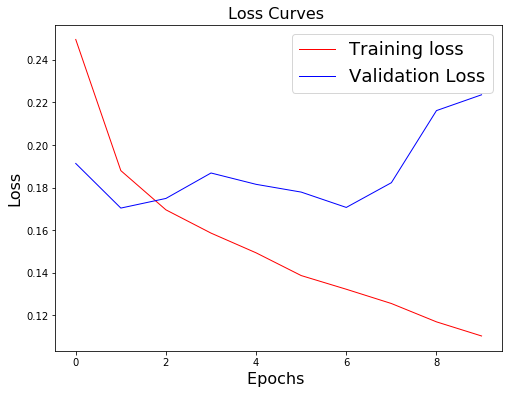

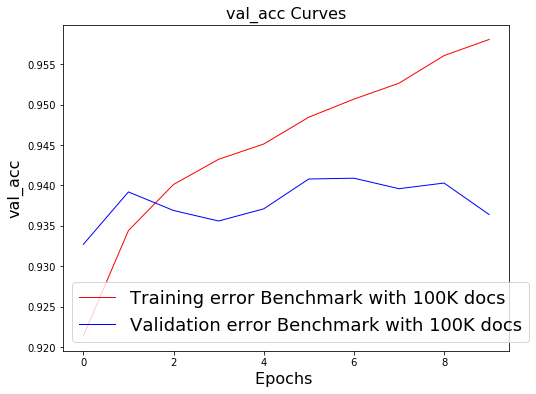

In [256]:
import p7_util
#legend='length='+str(max_length)
legend = "Benchmark with 100K docs"
model = None

list_model_acc_value = p7_util.p7_plot_cnn_history(model, None, None, history=history, legend=legend)

## Bias evaluation

In [246]:
import p9_util_metrics
df_bias_metrics = p9_util_metrics.compute_bias_metrics_for_model(df_validate, 
                                                                 p9_util_metrics.IDENTITY_COLUMNS, 
                                                                 MODEL_NAME, 
                                                                 p9_util_benchmark.TOXICITY_COLUMN)
df_bias_metrics

,bnsp_auc,bpsn_auc,subgroup,subgroup_auc,subgroup_size
6,0.945132,0.744650,black,0.743923,90
4,0.902987,0.846944,jewish,0.768519,35
2,0.972565,0.750301,homosexual_gay_or_lesbian,0.812585,60
7,0.963464,0.785766,white,0.814673,128
1,0.919671,0.893040,female,0.870294,295
5,0.972022,0.816112,muslim,0.890244,116
3,0.934728,0.926898,christian,0.920490,249
0,0.964967,0.892945,male,0.928365,266
8,0.970565,0.866941,psychiatric_or_mental_illness,0.938462,31


In [247]:
import p9_util_metrics
overall_auc = p9_util_metrics.calculate_overall_auc(df_validate, MODEL_NAME, p9_util_metrics.TOXICITY_COLUMN)
print("Global AUC= {}".format(overall_auc))

Global AUC= 0.9396671879981731


In [248]:
import p9_util_metrics

p9_util_metrics.get_final_metric(df_bias_metrics, overall_auc)

Bias score contribution : 0.6517429674190783


0.8866597644186216

## Binary classification performances

    Convert predictions and targets into binary values

In [249]:
df_validate['bool_predict'] = np.where(df_validate[MODEL_NAME] >= threshold, True, False)

df_validate['bin_predict'] = np.where(df_validate[MODEL_NAME] >= threshold, 1, 0)

df_validate['bin_target'] = np.where(df_validate['target'] == True, 1, 0)

In [251]:
df_validate[['target', MODEL_NAME, 'bool_predict','bin_target', 'bin_predict']].sample(3)

,target,predict,bool_predict,bin_target,bin_predict
940815,False,0.056333,False,0,0
1202215,False,0.003530,False,0,0
852267,False,0.010207,False,0,0


[0, 1]

Confusion matrix for all classes : 

[[9044  148]
 [ 378  430]]

Normalized confusion matrix
[[0.98389904 0.01610096]
 [0.46782178 0.53217822]]
Confusion matrix, without normalization
[[9044  148]
 [ 378  430]]

TP rate = [0.         0.53217822 1.        ]
FP rate = [0.         0.01610096 1.        ]
AUC = 0.7580386302337806


array([0, 0, 0, ..., 0, 0, 0])

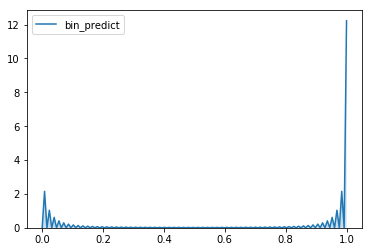

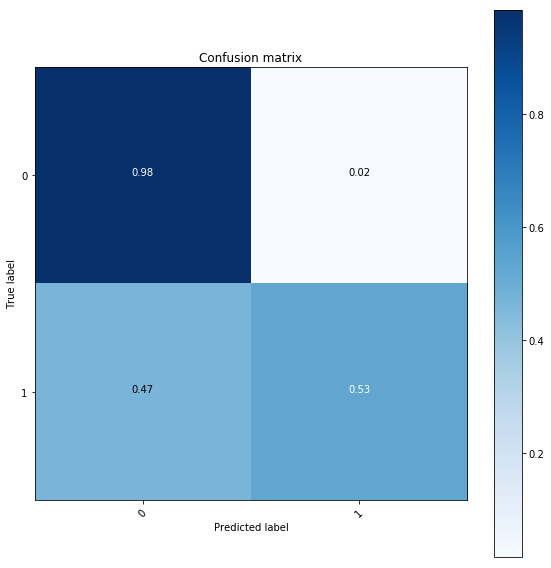

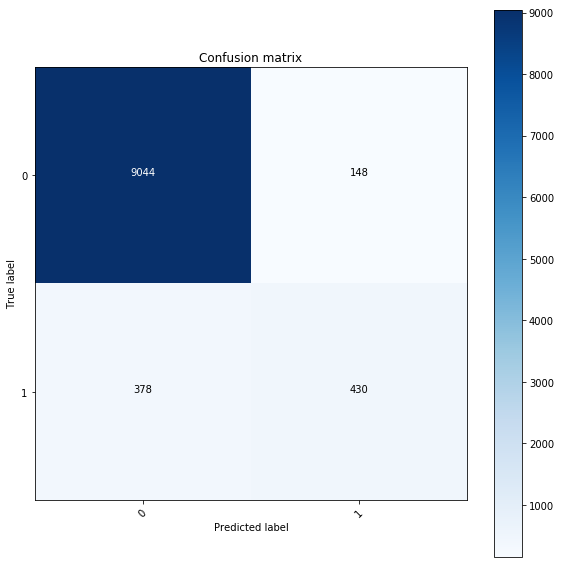

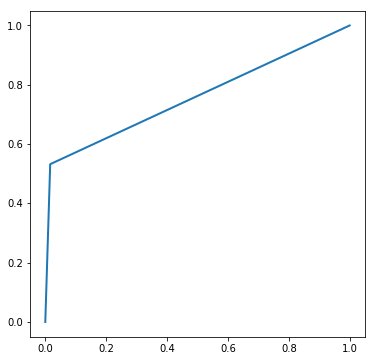

In [255]:
Xeval=None
p9_util.display_class_performance(model, Xeval, df_validate['bin_target'], \
                              is_binary=True, y_pred= df_validate['bin_predict'], nb_classes=2,\
                              title="Confusion matrix") 

# <font color='blus'>3. Submission algorithm</font>

    Submission algorithm is compared with benchmark algorithm using benchmark data-preparation.
    
    Switching from benchmark algorithm to submission is achieved thanks to model_type parameter 
    inside p9_util_benchmark.dict_param_benchmark configuration.
    

In [1]:
from sklearn import metrics
%matplotlib inline

%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings('ignore')

In [132]:
import p9_util_benchmark
p9_util_benchmark.dict_param_benchmark

{'root_directory': './data/benchmark/',
 'format_file': '.dill',
 'format_model': '.h5',
 'root_filename_benchmark': './data/benchmark/df_sample_benchmark_',
 'root_filename_model': 'model_jigsaw_',
 'n_sample': None,
 'n_sample_train': None,
 'is_dataset_reloaded': True,
 'model_type': 'submission',
 'is_model_reloaded': True,
 'is_embedding_layer': True,
 'threshold': 0.5,
 'embeddings_dimension': 100,
 'val_score_max': True,
 'epochs': 10}

In [3]:
import pandas as pd
from keras.preprocessing.text import Tokenizer
from sklearn import model_selection

import keras

import p5_util
import p9_util_benchmark

filename = './data/benchmark/model_jigsaw_benchmark.h5'

n_sample = p9_util_benchmark.dict_param_benchmark['n_sample']
filename_benchmark = p9_util_benchmark.build_filename_benchmark()
print(n_sample,filename_benchmark)

#-------------------------------------------------------------------------------
# Loading or building dataset
#-------------------------------------------------------------------------------
if p9_util_benchmark.dict_param_benchmark['is_dataset_reloaded'] :
   
    #-------------------------------------------------------------
    # Load validation dataframe
    #-------------------------------------------------------------
    filename_valid_dataset = p9_util_benchmark.build_filename_benchmark()
    df_validate = p5_util.object_load(filename_valid_dataset)

    #-------------------------------------------------------------
    # Load train dataframe
    #-------------------------------------------------------------
    filename_train_dataset = p9_util_benchmark.build_filename_benchmark(is_train=True)    
    df_train = p5_util.object_load(filename_train_dataset)
    
    #-------------------------------------------------------------
    # Load text tokenizer for data-preparation.
    #-------------------------------------------------------------
    tokenizer = p5_util.object_load(p9_util_benchmark.build_filename_tokenizer())
else :
    #-------------------------------------------------------------
    # Build dataset for train and validation, 
    #-------------------------------------------------------------
    df_train = pd.read_csv('./data/train.csv.zip', compression='zip', header=0, sep=',', quotechar='"')
    df_train['comment_text'] = df_train['comment_text'].apply(lambda x : x.lower())
    df_train['comment_text'] = df_train['comment_text'].astype(str)

    df_train = p9_util_benchmark.convert_dataframe_to_bool(df_train, \
                                                           dict_param_benchmark_=p9_util_benchmark.dict_param_benchmark)

    df_train, df_validate = model_selection.train_test_split(df_train, test_size=0.2)
    print('%d train comments, %d validation comments' % (len(df_train), len(df_validate)))
    
    #-------------------------------------------------------------
    # Save validation dataset into a file.
    #-------------------------------------------------------------
    if n_sample is None :
        n_sample = len(df_validate)
    else :
        pass    
    filename_valid_dataset = p9_util_benchmark.build_filename_benchmark()
    p5_util.object_dump(df_validate.sample(n_sample),filename_valid_dataset,is_verbose=True )
    
    #-------------------------------------------------------------
    # Save train dataset into a file.
    #-------------------------------------------------------------
    filename_train_dataset = p9_util_benchmark.build_filename_benchmark(is_train=True)
    p5_util.object_dump(df_train,filename_train_dataset,is_verbose=True )
    
    #-------------------------------------------------------------
    # Create a text tokenizer and save it.
    #-------------------------------------------------------------
    tokenizer = Tokenizer(num_words=p9_util_benchmark.MAX_NUM_WORDS)
    tokenizer.fit_on_texts(df_train[p9_util_benchmark.TEXT_COLUMN])
    filename_tokenizer = p9_util_benchmark.build_filename_tokenizer()
    p5_util.object_dump(tokenizer,filename_tokenizer, is_verbose=True )
    
    #-------------------------------------------------------------
    # Save parameters configuration into a file.
    #-------------------------------------------------------------
    filename_param = p9_util_benchmark.build_filename_param(p9_util_benchmark.dict_param_benchmark)
    p5_util.object_dump(p9_util_benchmark.dict_param_benchmark,filename_param, is_verbose=True )

None ./data/benchmark/df_sample_benchmark_valid_FULL.dill
p5_util.object_load : fileName= ./data/benchmark/df_sample_benchmark_valid_FULL.dill
p5_util.object_load : fileName= ./data/benchmark/df_sample_benchmark_train_FULL.dill
p5_util.object_load : fileName= ./data/benchmark/tokenizer_FULL.dill


    Below is the Keras configuration for CNN model.

In [4]:
import p9_util_config
p9_util_config.dict_param_keras_cnn

{'dict_param_keras': {'input_dim': (250, 100),
  'batch_size': 500,
  'nb_epoch': 10,
  'verbose': 1,
  'dropout_rate': 0.3,
  'regul': (None, None),
  'is_batch_normalized': True,
  'lr': 0.001,
  'nbClasses': 2},
 'filter_size': 3,
 'stride_size': 1,
 'pool_size': 2,
 'pool_stride': 2,
 'nb_filter': 256,
 'conv_layer': 4,
 'nb_dense_neuron': 128,
 'dense_layer': 1,
 'dense_layer_decrease_rate': 1,
 'list_channel': [],
 'list_filter_channel': []}

    Model is loaded from hard-disk.

In [133]:
import keras
import p5_util
import p9_util_benchmark

#-------------------------------------------------------------------------------
# Loading or building model
#-------------------------------------------------------------------------------    
if p9_util_benchmark.dict_param_benchmark['is_model_reloaded'] :
    #-------------------------------------------------------------
    # Load benchmark model.
    #-------------------------------------------------------------
    filename_model = p9_util_benchmark.build_filename_model()
    print("Loding model= {}".format(filename_model))
    model = keras.models.load_model(filename_model)
else :
    #-------------------------------------------------------------
    # Build benchmark model then save it.
    #-------------------------------------------------------------
    model,list_callback = p9_util_benchmark.build_model(p9_util_benchmark.dict_param_benchmark, \
                                                        p9_util_config.dict_param_keras_cnn)
    #model = p9_util_benchmark.train_benchmark_model(df_train, df_validate, tokenizer)

    filename_model = p9_util_benchmark.build_filename_model()
    model.save(filename_model)
    
        

Loding model= ./data/benchmark/model_jigsaw_submission_sampleFULL_threshold0.5_best.h5


In [139]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 250)               0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 250, 100)          35256200  
_________________________________________________________________
batch_normalization_1 (Batch (None, 250, 100)          400       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 250, 256)          51456     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 50, 256)           0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 50, 256)           1024      
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 50, 256)           196864    
__________

    Model is trained and best model is kept and saved on hard drive.

In [7]:
import p9_util_config
import p9_util_benchmark
model, history = p9_util_benchmark.train_benchmark_model(model, df_train, df_validate, tokenizer,
                                                         dict_param_keras_cnn=p9_util_config.dict_param_keras_cnn,
                                                        list_callback = list_callback)

Data preparation...

Batch size= 500
Model training...
Train on 1443899 samples, validate on 360975 samples
Epoch 1/10
1443899/1443899 [==============================] - 3270s 2ms/step - loss: 0.1650 - acc: 0.9424 - val_loss: 0.1541 - val_acc: 0.9447

Epoch 00001: val_acc improved from -inf to 0.94469, saving model to ./data/benchmark/model_jigsaw_submission_sampleFULL_threshold0.5_best.h5
Epoch 2/10
1443899/1443899 [==============================] - 3467s 2ms/step - loss: 0.1425 - acc: 0.9478 - val_loss: 0.1422 - val_acc: 0.9486

Epoch 00002: val_acc improved from 0.94469 to 0.94864, saving model to ./data/benchmark/model_jigsaw_submission_sampleFULL_threshold0.5_best.h5
Epoch 3/10
1443899/1443899 [==============================] - 3792s 3ms/step - loss: 0.1381 - acc: 0.9490 - val_loss: 0.1453 - val_acc: 0.9468

Epoch 00003: val_acc did not improve from 0.94864
Epoch 4/10
1443899/1443899 [==============================] - 2347s 2ms/step - loss: 0.1351 - acc: 0.9500 - val_loss: 0.1420 

In [8]:
import p5_util
import p9_util_benchmark

filename_history = p9_util_benchmark.build_filename_history(p9_util_benchmark.dict_param_benchmark)
p5_util.object_dump(history,filename_history, is_verbose=True)

object_dump: file name= ./data/benchmark/history_submission_100D_FULL_.dill


    Reload model with best performances.

In [9]:
import p9_util_keras
filename = './data/benchmark/model_jigsaw_submission_sampleFULL_threshold0.5_best.h5'
model = p9_util_keras.load_model(filename)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 250)               0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 250, 100)          35256200  
_________________________________________________________________
batch_normalization_1 (Batch (None, 250, 100)          400       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 250, 256)          51456     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 50, 256)           0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 50, 256)           1024      
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 50, 256)           196864    
__________

    Compute predictions over data for validation with best model

In [138]:
import p9_util_benchmark
MODEL_NAME = 'predict'

X_valid = p9_util_benchmark.pad_text( df_validate[p9_util_benchmark.TEXT_COLUMN],tokenizer)
df_validate[MODEL_NAME] = model.predict(X_valid, verbose=1)[:, 1]

360975/360975 [==============================] - 428s 1ms/step


    Compute bias metrics

In [169]:
import p9_util_metrics
df_bias_metrics = p9_util_metrics.compute_bias_metrics_for_model(df_validate, 
                                                                 p9_util_metrics.IDENTITY_COLUMNS, 
                                                                 MODEL_NAME, 
                                                                 p9_util_benchmark.TOXICITY_COLUMN)
df_bias_metrics

,bnsp_auc,bpsn_auc,subgroup,subgroup_auc,subgroup_size
6,0.966469,0.740035,black,0.800221,3006
2,0.969815,0.751545,homosexual_gay_or_lesbian,0.814692,2221
7,0.970046,0.757697,white,0.815955,5077
5,0.964107,0.795942,muslim,0.838105,4262
4,0.948720,0.850942,jewish,0.852908,1509
8,0.961080,0.833679,psychiatric_or_mental_illness,0.868066,982
0,0.954104,0.867933,male,0.885497,9050
1,0.951559,0.875196,female,0.890155,10671
3,0.940989,0.908634,christian,0.907710,8081


In [170]:
import p9_util_metrics
overall_auc = p9_util_metrics.calculate_overall_auc(df_validate, MODEL_NAME, p9_util_metrics.TOXICITY_COLUMN)
print("\nOverall AUC= {}".format(overall_auc))
p9_util_metrics.get_final_metric(df_bias_metrics, overall_auc)


Overall AUC= 0.9381508226117838
Bias score contribution : 0.6535991576775056


0.8881368633304516

    Evaluate binary classification performances.

In [164]:
df_validate.sample(3)

,id,target,comment_text,severe_toxicity,obscene,identity_attack,insult,threat,asian,atheist,...,likes,disagree,sexual_explicit,identity_annotator_count,toxicity_annotator_count,predict,bool_pred,bin_pred,bin_target,bool_target
662014,1051933,False,It depends on the model. If you go with the m...,0.0,0.0,0.0,0.0,0.0,NaN,NaN,...,1,0,0.0,0,6,0.000419,False,0,0,False
1429379,5866305,False,"uhhh,,,OK, so the Mediterranean diet is suppos...",0.0,0.0,0.0,0.0,0.0,NaN,NaN,...,5,1,0.0,0,10,0.002621,False,0,0,False
52576,306497,False,Nees you always crack me up. Always confirmin...,0.0,0.0,0.0,0.0,0.0,NaN,NaN,...,0,0,0.0,0,4,0.002830,False,0,0,False


In [161]:
df_validate['bool_pred'] = np.where(df_validate[MODEL_NAME] >= threshold, True, False)

In [152]:
df_validate['bin_pred'] = np.where(df_validate[MODEL_NAME] >= threshold, 1, 0)

In [158]:
df_validate['bool_target'] = np.where(df_validate['target'] >= threshold, True, False)

In [ ]:
df_validate['bin_target'] = np.where(df_validate['target'] >= threshold, 1, 0)

In [173]:
df_validate[['target','bin_target', 'bool_target', 'bin_pred', MODEL_NAME, 'bool_pred']].sample(3)

,target,bin_target,bool_target,bin_pred,predict,bool_pred
1138266,False,0,False,0,0.107711,False
483875,False,0,False,0,0.008861,False
189858,False,0,False,0,0.001195,False


In [153]:
df_validate['bin_target'] = np.where(df_validate['target'] >= threshold, 1, 0)

In [174]:
import p9_util_metrics
df_bias_metrics = p9_util_metrics.compute_bias_metrics_for_model(df_validate, 
                                                                 p9_util_metrics.IDENTITY_COLUMNS, 
                                                                 'predict', 
                                                                 'target')
df_bias_metrics

,bnsp_auc,bpsn_auc,subgroup,subgroup_auc,subgroup_size
6,0.966469,0.740035,black,0.800221,3006
2,0.969815,0.751545,homosexual_gay_or_lesbian,0.814692,2221
7,0.970046,0.757697,white,0.815955,5077
5,0.964107,0.795942,muslim,0.838105,4262
4,0.948720,0.850942,jewish,0.852908,1509
8,0.961080,0.833679,psychiatric_or_mental_illness,0.868066,982
0,0.954104,0.867933,male,0.885497,9050
1,0.951559,0.875196,female,0.890155,10671
3,0.940989,0.908634,christian,0.907710,8081


In [180]:
    from sklearn.metrics import confusion_matrix
    import p4_util
    
    list_classes = [0,1]
    title=""
    


Confusion matrix for all classes : 

[[328633   3613]
 [ 14859  13870]]

Normalized confusion matrix
[[0.98912553 0.01087447]
 [0.51721257 0.48278743]]


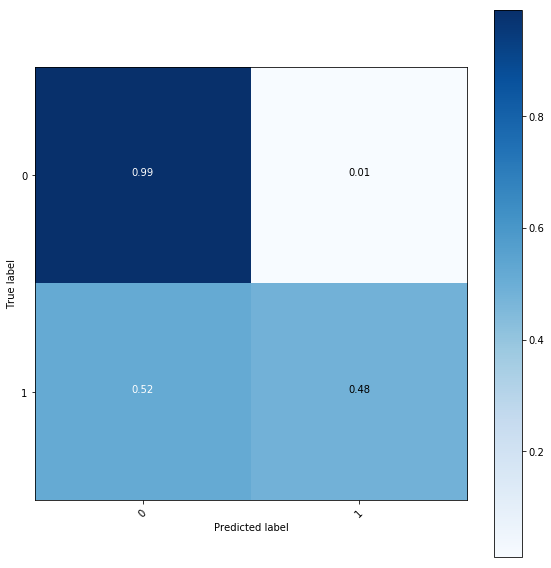

In [181]:
    #--------------------------------------------------------------
    # Compute confusion matrix
    #--------------------------------------------------------------
    print("\nConfusion matrix for all classes : ")
    print()
    print(metrics.confusion_matrix(df_validate['bin_target'], df_validate['bin_pred'], labels=list_classes))
    print()

    cm = confusion_matrix(df_validate['bin_target'], df_validate['bin_pred'])
    p4_util.plot_confusion_matrix(cm, list_classes,
                              normalize=True,
                              title=title,
                              cmap=plt.cm.Blues)
